<a href="https://colab.research.google.com/github/sznajder/CSC2026/blob/main/Optuna_MLP_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OPTUNA MLP optimization 

In [1]:
"""
Optuna example that optimizes a Keras model
"""
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import utils, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
 

import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState


print(f"TensorFlow {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    

# To disable GPU use
tf.config.set_visible_devices([], 'GPU')
print("Not using GPU !!!")    

seed = 175
nb_classes = 10
NTRIALS = 100
MTR='val_categorical_accuracy'
NEPOCHS = 100
BSIZES = [32,64,128]  # batch size for Optuna search
#BSIZES = [16,32,64]  # batch size for Optuna search
MINLR = 0.0001
MAXLR = 0.0005
MAXNL = 4 # maximum number of layer for Optuna search
MINNEU = 8 # minimum number of neurons per layer for Optuna search
MAXNEU = 96   # maximum number of neurons per layer for Optuna search
PATIEN = 20 # maximum pacience for early stop and checkpoint
REGL1 = 0.0001
outdir = "./optuna"


# OPTUNA trial syntax
# filters=trial.suggest_categorical("filters", [32, 64]),
# activation=trial.suggest_categorical("activation", ["relu", "linear"]),
# learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
# num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)       

/Users/sznajder/WorkM1/miniforge3/envs/hgq2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow 2.18.0
No GPU available, using CPU !!!
Not using GPU !!!


## Load MNIST Dataset

In [2]:
# Load MNIST dataset (28x28 pixel images)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("y_train=",y_train)
Y_train= utils.to_categorical(y_train, nb_classes)
print("Y_Train=",Y_train)
Y_test = utils.to_categorical(y_test, nb_classes)


y_train= [5 0 4 ... 5 6 8]
Y_Train= [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


## Define Functions : Optuna objetive and model constrution

In [3]:
# Optuna objective function
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    
    # early stopping callback
    es = EarlyStopping(monitor=MTR, patience=PATIEN)

    # Learning rate scheduler 
    ls = ReduceLROnPlateau(monitor=MTR, factor=0.8, patience=PATIEN, min_lr=0.00001)


    # model checkpoint callback to save best model architecture + parameters into bestmodel.h5
    chkp = ModelCheckpoint('bestmodel.keras', monitor=MTR, verbose=0, save_best_only=True, mode='auto', save_freq='epoch')

    # Optuna pruner callback to drop non promising trials 
    # BE CAREFULL as this might bias towards faster learning models with lower performance at the end of traing !!!
    pru = optuna.integration.TFKerasPruningCallback(trial, monitor=MTR)


    # Create the model
    model = create_model(trial)

    # Fit the model
    history = model.fit(X_train, Y_train, 
              batch_size= trial.suggest_categorical("bsize", BSIZES),  
              epochs=NEPOCHS, 
              verbose=0,
              validation_split=0.2,
              callbacks=[es,ls,chkp],
              shuffle=True,
              )

    
    # Load the best saved model
    model = tf.keras.models.load_model( 'bestmodel.keras',)
    

    # Plot Loss and Accuracy versus Epoch
    
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val loss')
    ax.legend(loc="upper right")
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # Plot training accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    #ax.plot(history.history['accuracy'], label='accuracy')
    #ax.plot(history.history['val_accuracy'], label='val accuracy')
    ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
    ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
    ax.legend(loc="upper left")
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Display plots
    fig = plt.gcf()
    plt.show()
#    fig.savefig(fname+'.pdf')
        
    Y_pred = model.predict(X_test)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    accuracy.update_state(Y_test, Y_pred)
    return accuracy.result().numpy()   
    
# Model constrution
def create_model(trial):
    model = Sequential()

    # Define the MLP.
    nlayers = trial.suggest_int("nlayers", 1, MAXNL)
    model = Sequential()
    model.add(Input(shape=(784,)))   # Flattened input shape
    for i in range(nlayers):
        nhidden = trial.suggest_int("nhidden_l{}".format(i), MINNEU, MAXNEU, log=True)
        model.add( Dense(nhidden, name=f'dense_{i}' ,activation="relu" , kernel_regularizer=regularizers.L1(REGL1), bias_regularizer=regularizers.L1(REGL1) ) )
    model.add( Dense(nb_classes, name=f'dense_out'  , activation="softmax", kernel_regularizer=regularizers.L1(REGL1), bias_regularizer=regularizers.L1(REGL1) ) )

    
    # Define the optimizer
    optim = Adam( learning_rate= trial.suggest_float("learning_rate", MINLR, MAXLR, log=True) )

# compile the model
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
    model.summary(expand_nested=True)
    return model
    


[I 2026-01-21 15:40:44,513] Using an existing study with name 'mlp_study' instead of creating a new one.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 79)             │        62,015 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           230 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,593 (248.41 KB)

 Trainable params: 63,593 (248.41 KB)

 Non-trainable params: 0 (0.00 B)

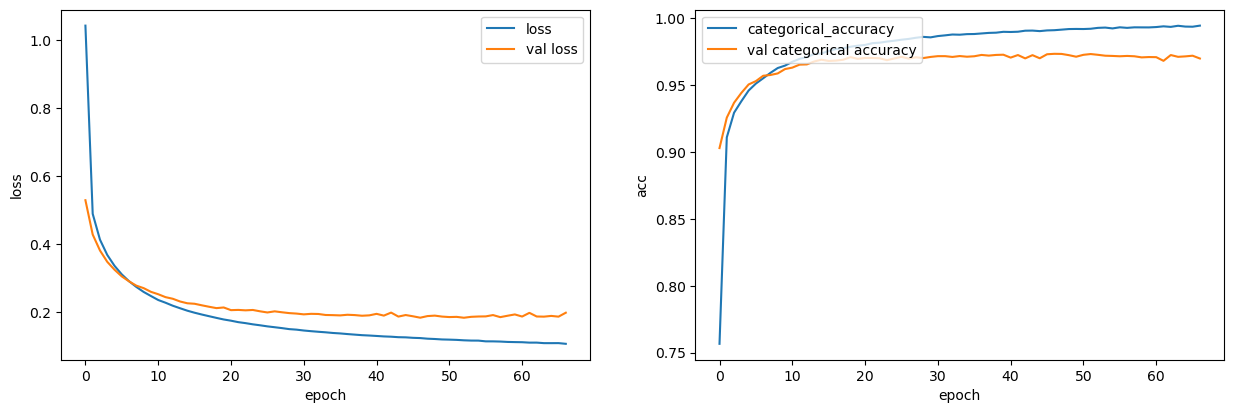

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


[I 2026-01-21 15:42:20,538] Trial 2 finished with value: 0.9745000004768372 and parameters: {'nlayers': 3, 'nhidden_l0': 79, 'nhidden_l1': 13, 'nhidden_l2': 22, 'learning_rate': 0.00013423892303721132, 'bsize': 32}. Best is trial 2 with value: 0.9745000004768372.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 17)             │        13,345 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           180 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,525 (52.83 KB)

 Trainable params: 13,525 (52.83 KB)

 Non-trainable params: 0 (0.00 B)

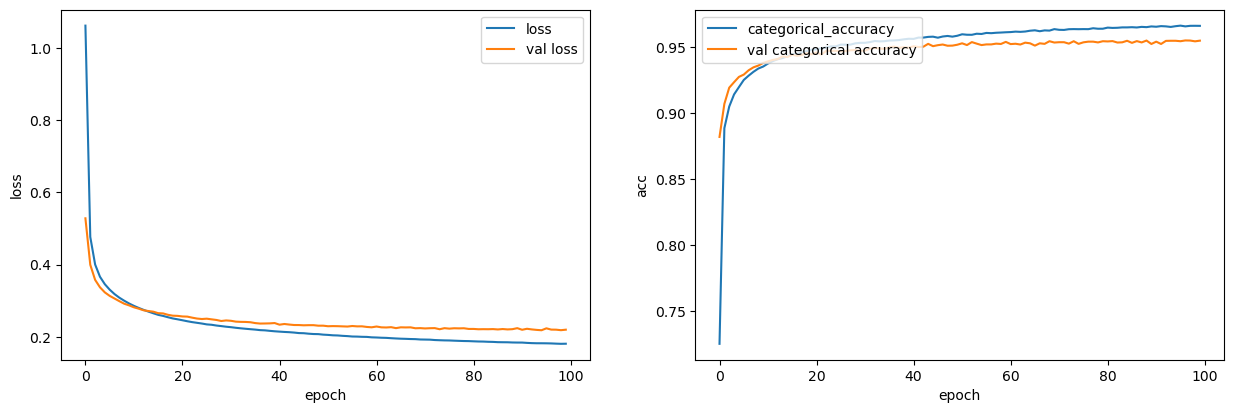

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


[I 2026-01-21 15:42:52,753] Trial 3 finished with value: 0.957099974155426 and parameters: {'nlayers': 1, 'nhidden_l0': 17, 'learning_rate': 0.0004603490744181986, 'bsize': 128}. Best is trial 2 with value: 0.9745000004768372.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 47)             │        36,895 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,553 (146.69 KB)

 Trainable params: 37,553 (146.69 KB)

 Non-trainable params: 0 (0.00 B)

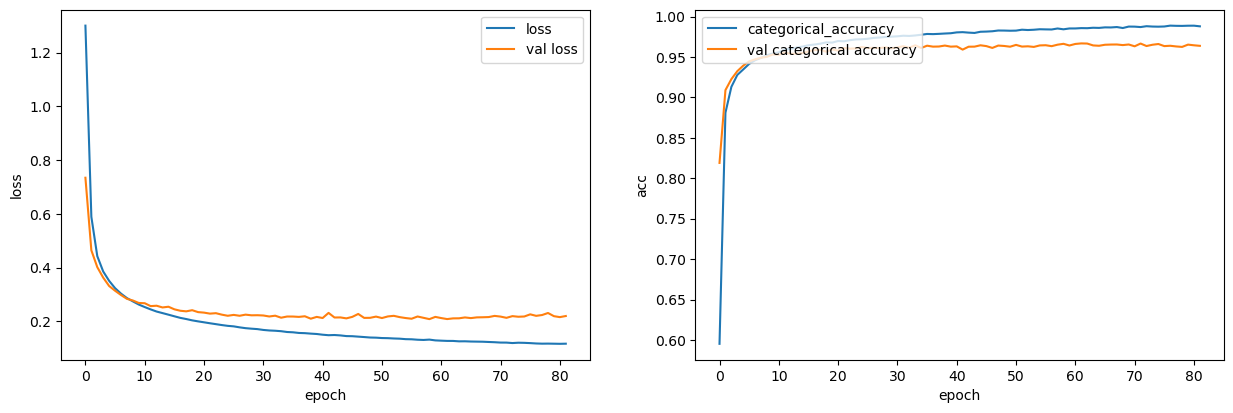

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


[I 2026-01-21 15:43:47,680] Trial 4 finished with value: 0.9649999737739563 and parameters: {'nlayers': 3, 'nhidden_l0': 47, 'nhidden_l1': 10, 'nhidden_l2': 8, 'learning_rate': 0.0003205093288451398, 'bsize': 64}. Best is trial 2 with value: 0.9745000004768372.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 60)             │        47,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 39)             │         2,379 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,879 (194.84 KB)

 Trainable params: 49,879 (194.84 KB)

 Non-trainable params: 0 (0.00 B)

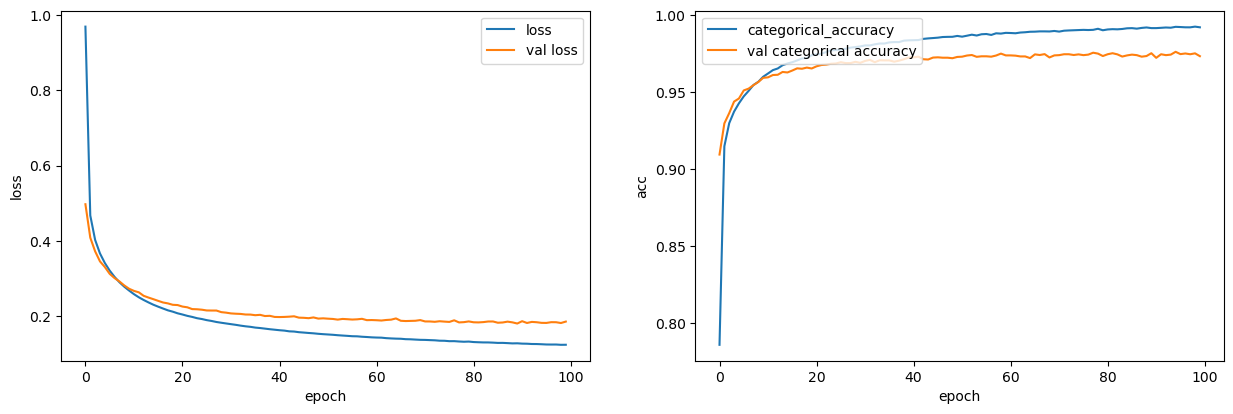

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


[I 2026-01-21 15:45:50,491] Trial 5 finished with value: 0.9733999967575073 and parameters: {'nlayers': 2, 'nhidden_l0': 60, 'nhidden_l1': 39, 'learning_rate': 0.00012428397262159388, 'bsize': 32}. Best is trial 2 with value: 0.9745000004768372.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 37)             │        29,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,439 (115.00 KB)

 Trainable params: 29,439 (115.00 KB)

 Non-trainable params: 0 (0.00 B)

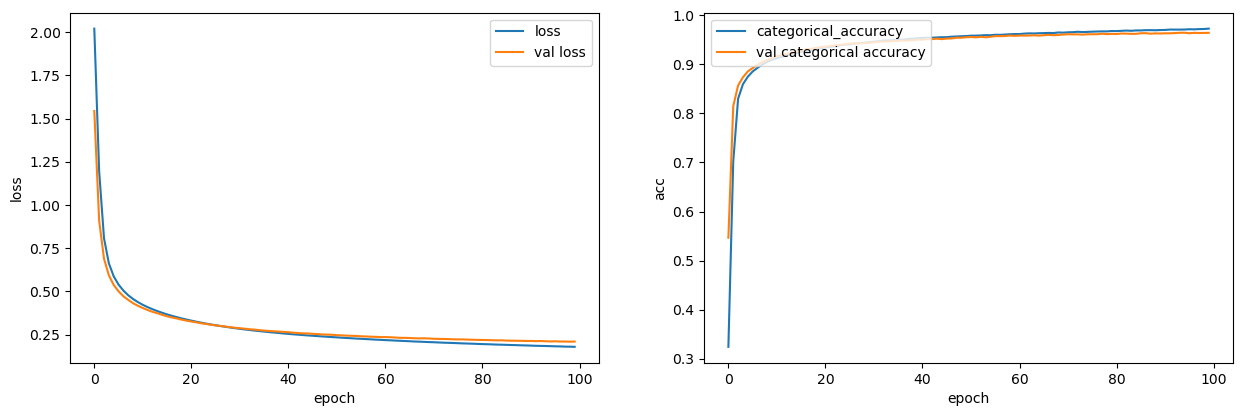

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


[I 2026-01-21 15:46:27,916] Trial 6 finished with value: 0.9595000147819519 and parameters: {'nlayers': 2, 'nhidden_l0': 37, 'nhidden_l1': 8, 'learning_rate': 0.00011007227389409085, 'bsize': 128}. Best is trial 2 with value: 0.9745000004768372.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 18)             │        14,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           247 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │           294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           286 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,097 (58.97 KB)

 Trainable params: 15,097 (58.97 KB)

 Non-trainable params: 0 (0.00 B)

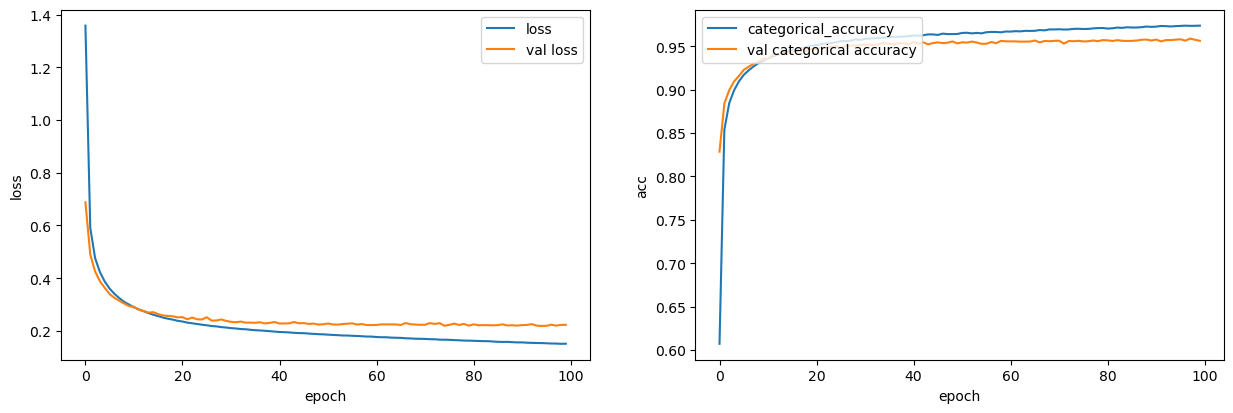

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


[I 2026-01-21 15:47:27,279] Trial 7 finished with value: 0.9563999772071838 and parameters: {'nlayers': 4, 'nhidden_l0': 18, 'nhidden_l1': 13, 'nhidden_l2': 21, 'nhidden_l3': 13, 'learning_rate': 0.0002074924134868057, 'bsize': 64}. Best is trial 2 with value: 0.9745000004768372.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 22)             │        17,270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           230 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,500 (68.36 KB)

 Trainable params: 17,500 (68.36 KB)

 Non-trainable params: 0 (0.00 B)

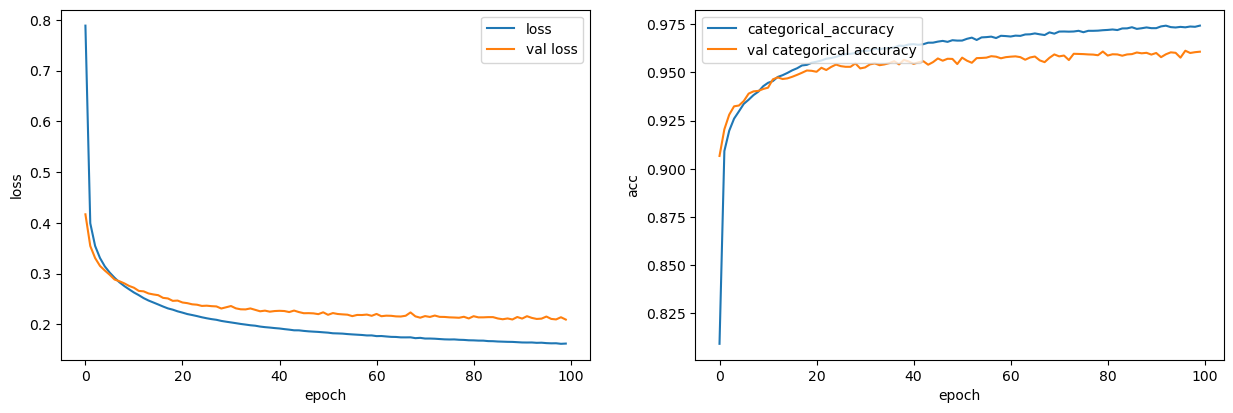

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


[I 2026-01-21 15:48:22,454] Trial 8 finished with value: 0.9617999792098999 and parameters: {'nlayers': 1, 'nhidden_l0': 22, 'learning_rate': 0.0004343797450377613, 'bsize': 64}. Best is trial 2 with value: 0.9745000004768372.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 17)             │        13,345 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           180 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,525 (52.83 KB)

 Trainable params: 13,525 (52.83 KB)

 Non-trainable params: 0 (0.00 B)

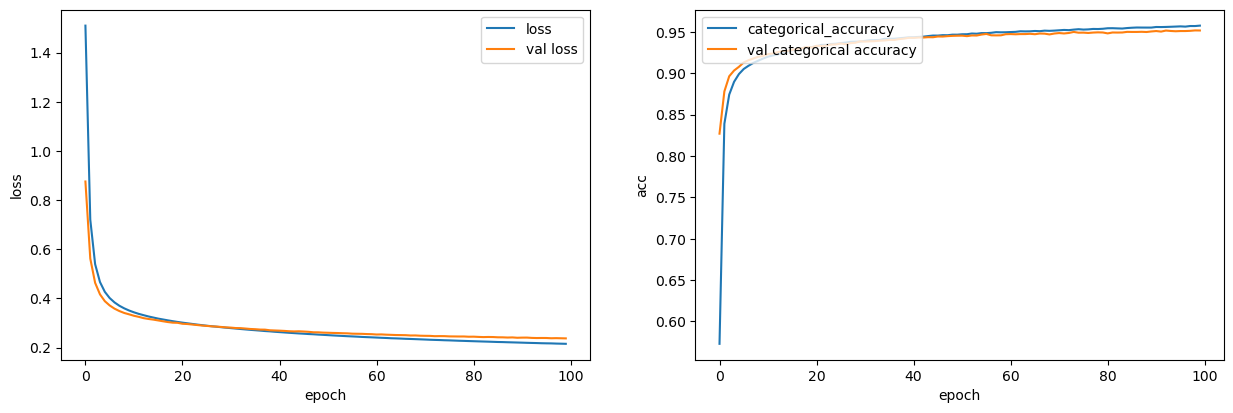

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


[I 2026-01-21 15:49:14,168] Trial 9 finished with value: 0.9492999911308289 and parameters: {'nlayers': 1, 'nhidden_l0': 17, 'learning_rate': 0.00011553660005898053, 'bsize': 64}. Best is trial 2 with value: 0.9745000004768372.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 71)             │        55,735 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,455 (220.53 KB)

 Trainable params: 56,455 (220.53 KB)

 Non-trainable params: 0 (0.00 B)

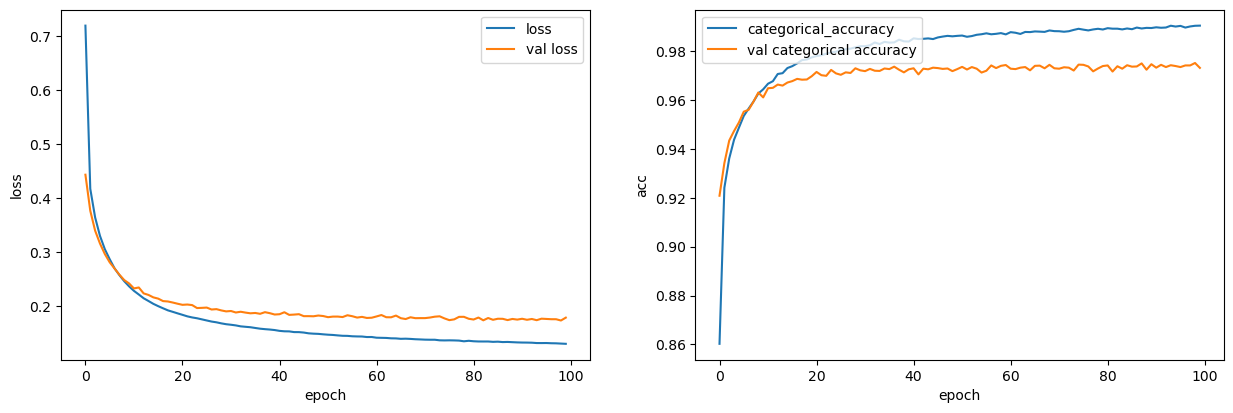

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


[I 2026-01-21 15:50:24,654] Trial 10 finished with value: 0.9768000245094299 and parameters: {'nlayers': 1, 'nhidden_l0': 71, 'learning_rate': 0.00036159874842231574, 'bsize': 64}. Best is trial 10 with value: 0.9768000245094299.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 52)             │        40,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           742 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,712 (162.94 KB)

 Trainable params: 41,712 (162.94 KB)

 Non-trainable params: 0 (0.00 B)

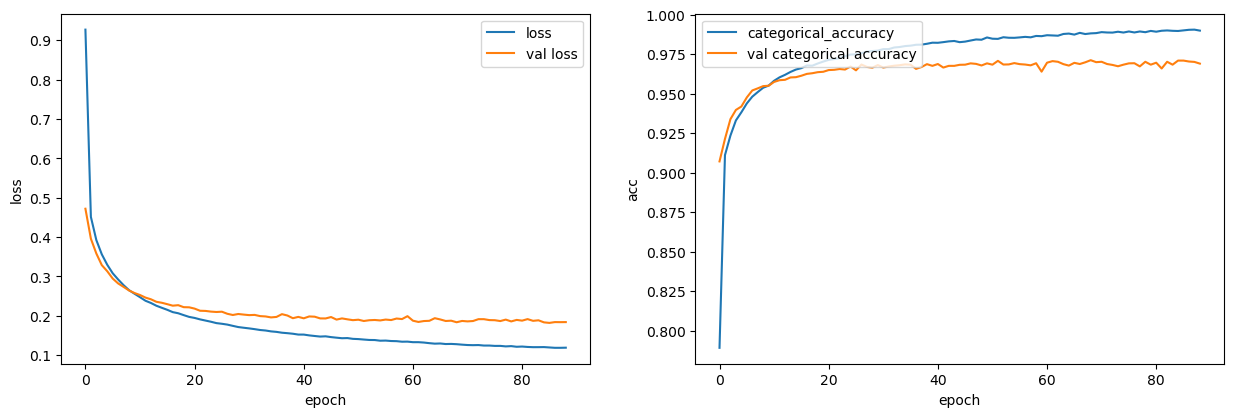

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


[I 2026-01-21 15:50:59,607] Trial 11 finished with value: 0.9718999862670898 and parameters: {'nlayers': 2, 'nhidden_l0': 52, 'nhidden_l1': 14, 'learning_rate': 0.000417348806275769, 'bsize': 128}. Best is trial 10 with value: 0.9768000245094299.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │           810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 93)             │         8,463 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │         7,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           760 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,363 (91.26 KB)

 Trainable params: 23,363 (91.26 KB)

 Non-trainable params: 0 (0.00 B)

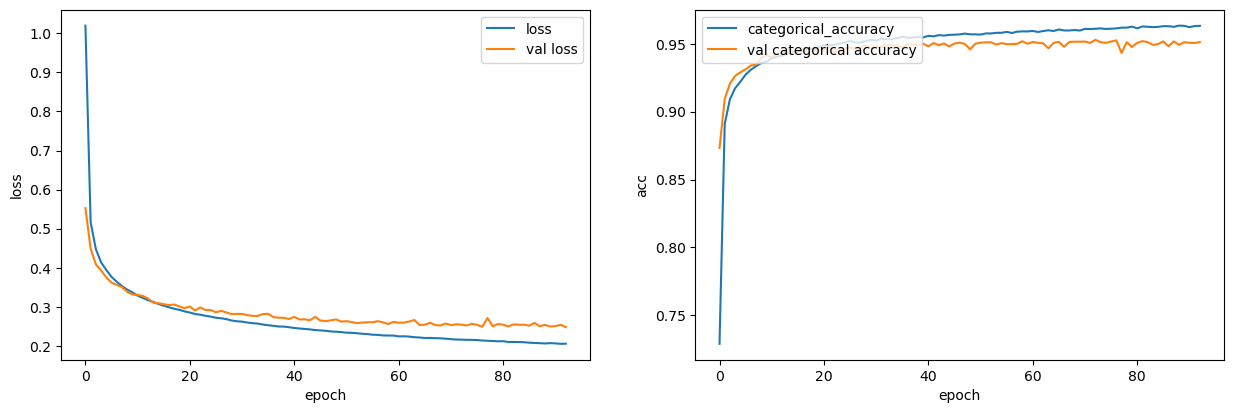

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


[I 2026-01-21 15:52:02,579] Trial 12 finished with value: 0.95169997215271 and parameters: {'nlayers': 4, 'nhidden_l0': 8, 'nhidden_l1': 90, 'nhidden_l2': 93, 'nhidden_l3': 75, 'learning_rate': 0.00026021405440074924, 'bsize': 64}. Best is trial 10 with value: 0.9768000245094299.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 93)             │        73,005 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         2,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │           675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,216 (297.72 KB)

 Trainable params: 76,216 (297.72 KB)

 Non-trainable params: 0 (0.00 B)

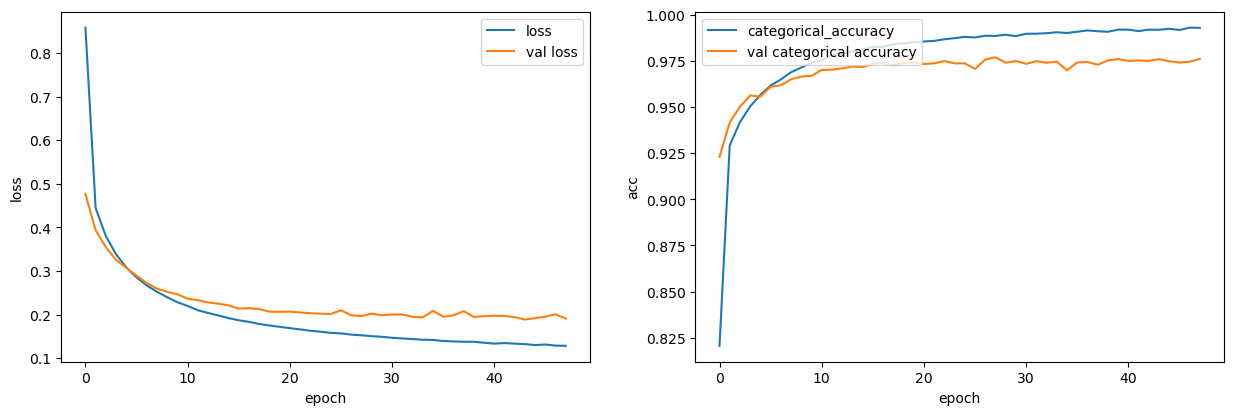

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


[I 2026-01-21 15:53:14,001] Trial 13 finished with value: 0.9757999777793884 and parameters: {'nlayers': 3, 'nhidden_l0': 93, 'nhidden_l1': 24, 'nhidden_l2': 27, 'learning_rate': 0.00018502657696801777, 'bsize': 32}. Best is trial 10 with value: 0.9768000245094299.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 94)             │        73,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         2,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,274 (309.66 KB)

 Trainable params: 79,274 (309.66 KB)

 Non-trainable params: 0 (0.00 B)

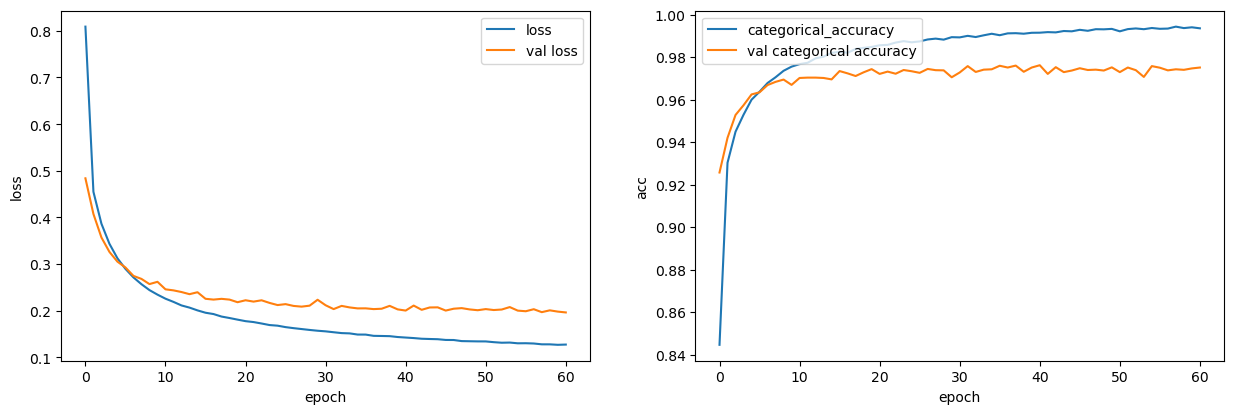

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


[I 2026-01-21 15:54:46,445] Trial 14 finished with value: 0.9775999784469604 and parameters: {'nlayers': 3, 'nhidden_l0': 94, 'nhidden_l1': 30, 'nhidden_l2': 64, 'learning_rate': 0.00019138435999449638, 'bsize': 32}. Best is trial 14 with value: 0.9775999784469604.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 33)             │        25,905 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 51)             │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 81)             │         4,212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,671 (127.62 KB)

 Trainable params: 32,671 (127.62 KB)

 Non-trainable params: 0 (0.00 B)

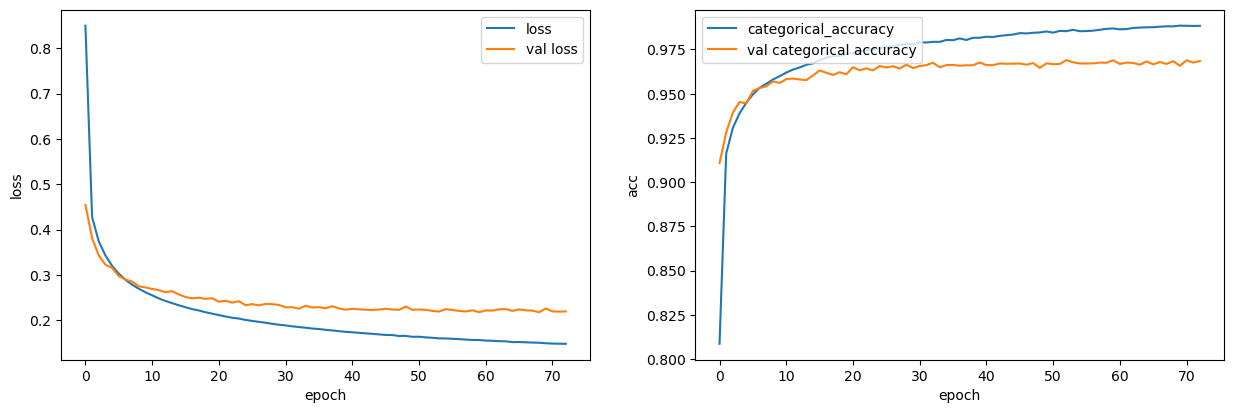

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


[I 2026-01-21 15:56:07,309] Trial 15 finished with value: 0.9667999744415283 and parameters: {'nlayers': 3, 'nhidden_l0': 33, 'nhidden_l1': 51, 'nhidden_l2': 81, 'learning_rate': 0.00015901144386362462, 'bsize': 32}. Best is trial 14 with value: 0.9775999784469604.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 72)             │        56,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         1,898 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           270 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,688 (229.25 KB)

 Trainable params: 58,688 (229.25 KB)

 Non-trainable params: 0 (0.00 B)

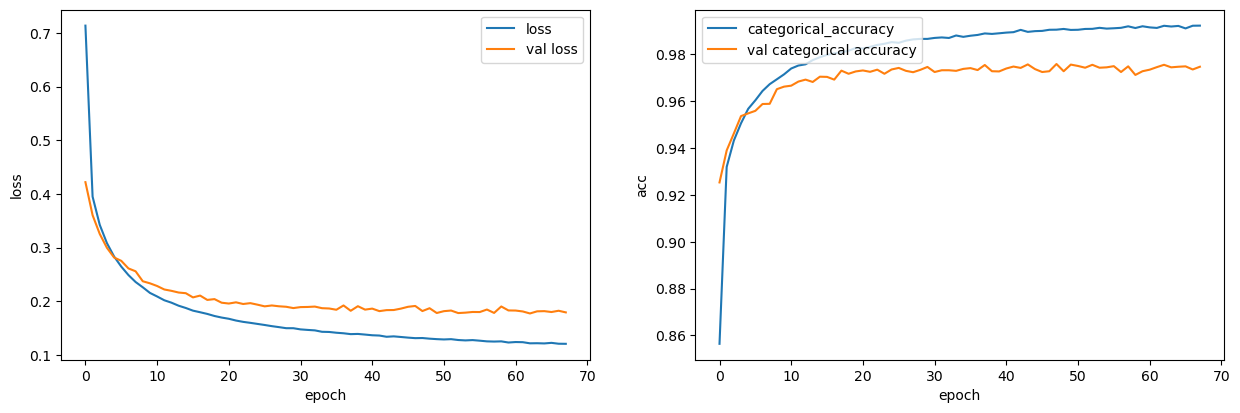

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step


[I 2026-01-21 15:57:37,767] Trial 16 finished with value: 0.9754999876022339 and parameters: {'nlayers': 2, 'nhidden_l0': 72, 'nhidden_l1': 26, 'learning_rate': 0.00027992252659354253, 'bsize': 32}. Best is trial 14 with value: 0.9775999784469604.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 70)             │        54,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 66)             │         4,686 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         2,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,734 (245.05 KB)

 Trainable params: 62,734 (245.05 KB)

 Non-trainable params: 0 (0.00 B)

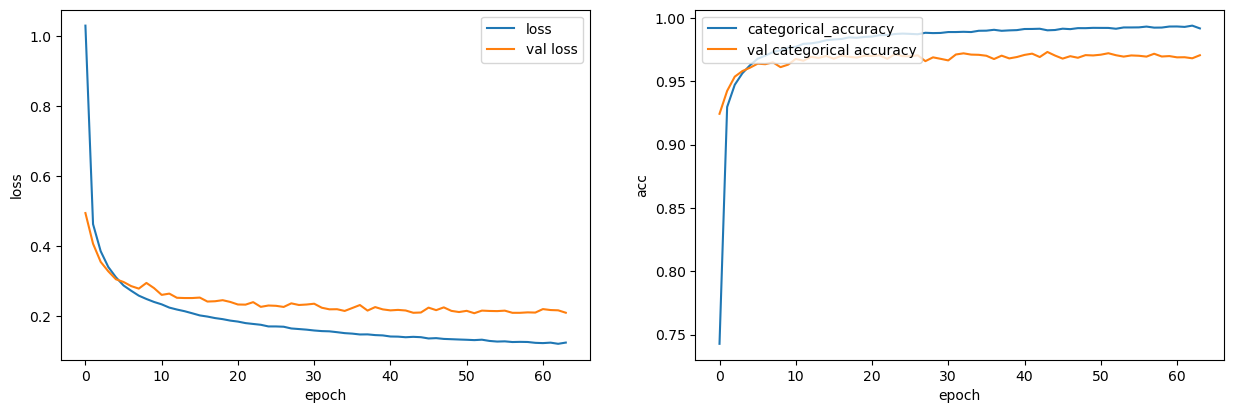

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


[I 2026-01-21 15:58:30,024] Trial 17 finished with value: 0.9743000268936157 and parameters: {'nlayers': 4, 'nhidden_l0': 70, 'nhidden_l1': 66, 'nhidden_l2': 40, 'nhidden_l3': 8, 'learning_rate': 0.0003506110762927222, 'bsize': 64}. Best is trial 14 with value: 0.9775999784469604.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 96)             │        75,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (None, 10)             │           970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,330 (298.16 KB)

 Trainable params: 76,330 (298.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
  # Set Optuna
study = optuna.create_study(
        study_name="mlp_study",
        sampler=optuna.samplers.TPESampler(),
        direction="maximize",
        storage="sqlite:///optuna_mlp_mnist.db",
        load_if_exists=True,
    )


# Optimize
study.optimize(objective, n_trials=NTRIALS, gc_after_trial=True)

## Print Optuna Results

In [ ]:

# Results

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



#trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
#trials = study.get_trials(deepcopy=False)
#print("Study statistics: ")
#print("  Number of finished trials: ", len(study.trials))
#print("  Number of trials: ", len(trials))

    
# reload study and continue optimizing
#study = optuna.load_study(study_name="example-study", storage="sqlite:///example.db")
#study.optimize(objective, n_trials=30)    

